### Inport necessary packages

In [220]:
import torch
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [221]:
import matplotlib.pyplot as plt

In [222]:
import random
import numpy as np

In [223]:
import torch.nn as nn
import torch.nn.functional as F

In [224]:
import os
import cv2

In [225]:
seed = 21520063

In [226]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

### Load Folio Leaf Dataset

In [227]:
root_dir = 'Folio Leaf Dataset' # Example: '/content/drive/MyDrive/CS115/Folio Leaf Dataset'

In [228]:
list_folders = os.listdir(root_dir)
list_folders

['ashanti blood',
 'barbados cherry',
 'beaumier du perou',
 'betel',
 'bitter orange',
 'caricature plant',
 'chinese guava',
 'chocolate tree',
 'chrysanthemum',
 'coeur demoiselle',
 'coffee',
 'croton',
 'duranta gold',
 'eggplant',
 'ficus',
 'fruitcitere',
 'geranium',
 'guava',
 'hibiscus',
 'jackfruit',
 'ketembilla',
 'lychee',
 'mulberry leaf',
 'papaya',
 'pimento',
 'pomme jacquot',
 'rose',
 'star apple',
 'sweet olive',
 'sweet potato',
 'thevetia',
 'vieux garcon']

In [229]:
def resize(image):
    return cv2.resize(image, (232, 412))

### Process the raw data

In [230]:
# Create dataset (X, y)
X, y = [], []
for folder in list_folders:
  list_image_paths = os.listdir(root_dir + '/' + folder)
  for image_path in list_image_paths:
    img_matrix = resize(cv2.imread(root_dir + '/' + folder + '/' + image_path, 0))
    X.append([img_matrix])
    y.append(folder)

In [231]:
# Task: Normalize the value of each pixel by dividing them to 255
X_normalize= np.array(X)/255

In [232]:
# Task: Perform 'label encoding' on y
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [233]:
y = le.fit_transform(y)

### Create the train/test set

In [234]:
# Task: Split dataset into training and testing set (7:3, random_seed = Your Student ID)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_normalize, y, train_size=0.7, random_state=21520063)

In [251]:
# Task: Convert the data type of X_train, X_test, y_train, y_test to 'Tensor'
# Identify as float to match Train_model design
X_train = torch.from_numpy(np.array(X_train)).float()
X_test = torch.from_numpy(np.array(X_test)).float()
y_train = torch.from_numpy( np.array(y_train))
y_test = torch.from_numpy(np.array(y_test))

In [252]:
# Task: Create train_dataset, test_dataset
from torch.utils.data import TensorDataset
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

In [253]:
# Task: Create train_loader (batch_size = 64), test_loader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset)

### Implement Classifiers

In [254]:
# Task: Implement "Logistic Regression" model with PyTorch
class LogisticRegression(nn.Module):
    # input_dim -> the number of independent variables (attributes)
    # output_dim -> the number of (unique) classes for classification (e.g., dog-cat -> 2; car-bicycle-plane -> 3)
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        logits = self.linear(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs

In [255]:
import torch.optim as optim

In [256]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [257]:
# Task: Design the 'train_model' function for training models
# Loss Function: Cross Entropy Loss
# Optimizer: Adam -> optim.Adam(model.parameters(), lr=...)
def train_model(data_loader, model, init_lr, Maxepoch):
    critetion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr = init_lr)
    loss_each_epoch = []
    model.train()
    for epoch in range(Maxepoch):
        sumloss = 0.0
        for(imgs, labels) in data_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            imgs = imgs.reshape(imgs.shape[0],-1)
            #forward
            logits, _ = model(imgs)
            loss = critetion(logits,labels)
            #backward
            optimizer.zero_grad()
            loss.backward()

            optimizer.step()

            sumloss+= loss.item()
        loss_each_epoch.append(sumloss/len(data_loader.dataset))
        print(f'Epoch {epoch+1}\{Maxepoch}, Loss {loss_each_epoch[-1]:.2} ')
    return loss_each_epoch

In [260]:
# Task: Design the 'model_evaluation' function for evaluating the trained models
def model_evaluation(data_loader, model):
    nCorrects = 0
    model.eval()  # put our model on the evaluation mode

    with torch.no_grad():
        for (imgs, labels) in data_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            imgs = imgs.reshape(imgs.shape[0], -1)

            # forward
            _, probs = model(imgs)
            _, y_pred = probs.max(1)
            nCorrects += (y_pred == labels).sum()
    print(f'We got {nCorrects.item()}/{len(data_loader.dataset)} correct. Accuracy = {nCorrects.item()/len(data_loader.dataset) * 100:.2f}%')

In [258]:
# Train Logistic Regression model
Input_dim = 412 * 232
Output_dim = 32
Lrate= 0.001
Max_Epoch = 600
clf_LR = LogisticRegression(input_dim=Input_dim, output_dim=Output_dim).to(device)
loss_each_epoch_LR = train_model(data_loader=train_loader, model=clf_LR, init_lr=Lrate, Maxepoch=Max_Epoch)

Epoch 1\600, Loss 1.6 
Epoch 2\600, Loss 2.9 
Epoch 3\600, Loss 4.6 
Epoch 4\600, Loss 5.2 
Epoch 5\600, Loss 3.9 
Epoch 6\600, Loss 2.2 
Epoch 7\600, Loss 1.6 
Epoch 8\600, Loss 1.0 
Epoch 9\600, Loss 0.64 
Epoch 10\600, Loss 0.39 
Epoch 11\600, Loss 0.25 
Epoch 12\600, Loss 0.13 
Epoch 13\600, Loss 0.094 
Epoch 14\600, Loss 0.056 
Epoch 15\600, Loss 0.051 
Epoch 16\600, Loss 0.035 
Epoch 17\600, Loss 0.031 
Epoch 18\600, Loss 0.024 
Epoch 19\600, Loss 0.023 
Epoch 20\600, Loss 0.023 
Epoch 21\600, Loss 0.024 
Epoch 22\600, Loss 0.02 
Epoch 23\600, Loss 0.032 
Epoch 24\600, Loss 0.02 
Epoch 25\600, Loss 0.019 
Epoch 26\600, Loss 0.018 
Epoch 27\600, Loss 0.021 
Epoch 28\600, Loss 0.012 
Epoch 29\600, Loss 0.019 
Epoch 30\600, Loss 0.021 
Epoch 31\600, Loss 0.016 
Epoch 32\600, Loss 0.018 
Epoch 33\600, Loss 0.03 
Epoch 34\600, Loss 0.034 
Epoch 35\600, Loss 0.02 
Epoch 36\600, Loss 0.027 
Epoch 37\600, Loss 0.0094 
Epoch 38\600, Loss 0.0089 
Epoch 39\600, Loss 0.0065 
Epoch 40\600, Lo

Text(0.5, 1.0, 'LogisticRegression')

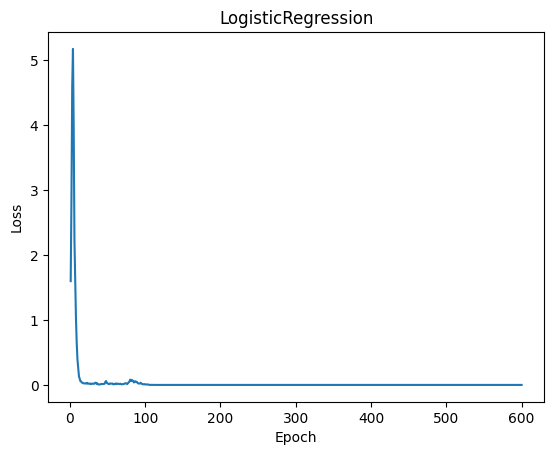

In [259]:
plt.plot(range(1, len(loss_each_epoch_LR) + 1), loss_each_epoch_LR)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('LogisticRegression')

In [261]:
print('Logistic Regression (Train Accuracy)')
model_evaluation(data_loader=train_loader, model=clf_LR)

Logistic Regression (Train Accuracy)
We got 445/445 correct. Accuracy = 100.00%


In [262]:
print('Logistic Regression (Test Accuracy)')
model_evaluation(data_loader=test_loader, model=clf_LR)

Logistic Regression (Test Accuracy)
We got 148/192 correct. Accuracy = 77.08%


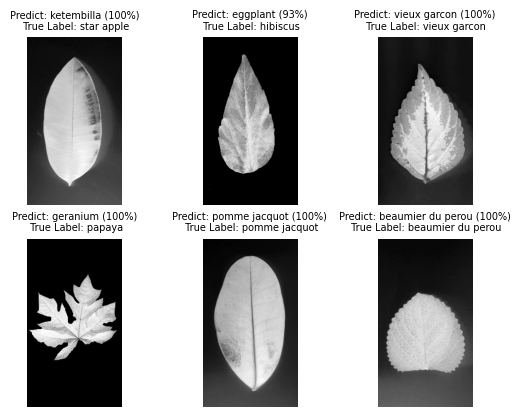

In [263]:
ROW_IMG, N_ROWS = 3, 2

fig = plt.figure()
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    plt.imshow(test_dataset[index][0].squeeze(), cmap='gray_r')
    
    with torch.no_grad():
        clf_LR.eval()
        X = test_dataset[index][0].reshape(test_dataset[index][0].shape[0], -1).to(device)
        _, probs = clf_LR(X)
    title = f'Predict: {le.inverse_transform([torch.argmax(probs).item()])[0]} ({torch.max(probs * 100):.0f}%)\n True Label: {le.inverse_transform([test_dataset[index][-1]])[0]}'
    
    plt.title(title, fontsize=7)
plt.show()

In [266]:
# Task: Build a MLP model with 6 layers (input layer, ouput layer and 4 hidden layers)
# The activation of each node in 'input' layer and 'hidden' layers is ReLU
# Information about each layer:
# + Input layer: (input_dim, 2048)
# + Hidden layer 1: (2048, 1024)
# + Hidden layer 2: (1024, 1024)
# + Hidden layer 3: (1024, 512)
# + Hidden layer 4: (512, 512)
# + Output layer: (512, output_dim)
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, 2048),
            nn.ReLU(),
            nn.Linear(2048,1024),
            nn.ReLU(),
            nn.Linear(1024,1024),
            nn.ReLU(),
            nn.Linear(1024,512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, output_dim)
        )

    def forward(self, x):
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs

In [267]:
clf_MLP = MLP(input_dim=412 * 232, output_dim=32).to(device)
clf_MLP

MLP(
  (classifier): Sequential(
    (0): Linear(in_features=95584, out_features=2048, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2048, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=1024, bias=True)
    (5): ReLU()
    (6): Linear(in_features=1024, out_features=512, bias=True)
    (7): ReLU()
    (8): Linear(in_features=512, out_features=512, bias=True)
    (9): ReLU()
    (10): Linear(in_features=512, out_features=32, bias=True)
  )
)

In [268]:
# Train MLP model
# Input dim = 412 * 233
# Output dim = 32
LRate= 0.001
Max_Epoch = 600
loss_each_epoch_MLP=train_model(train_loader,clf_MLP,init_lr=LRate,Maxepoch=Max_Epoch)

Epoch 1\600, Loss 0.085 
Epoch 2\600, Loss 0.056 
Epoch 3\600, Loss 0.056 
Epoch 4\600, Loss 0.055 
Epoch 5\600, Loss 0.055 
Epoch 6\600, Loss 0.055 
Epoch 7\600, Loss 0.054 
Epoch 8\600, Loss 0.054 
Epoch 9\600, Loss 0.054 
Epoch 10\600, Loss 0.053 
Epoch 11\600, Loss 0.051 
Epoch 12\600, Loss 0.048 
Epoch 13\600, Loss 0.047 
Epoch 14\600, Loss 0.044 
Epoch 15\600, Loss 0.04 
Epoch 16\600, Loss 0.04 
Epoch 17\600, Loss 0.038 
Epoch 18\600, Loss 0.035 
Epoch 19\600, Loss 0.033 
Epoch 20\600, Loss 0.036 
Epoch 21\600, Loss 0.035 
Epoch 22\600, Loss 0.032 
Epoch 23\600, Loss 0.031 
Epoch 24\600, Loss 0.031 
Epoch 25\600, Loss 0.031 
Epoch 26\600, Loss 0.029 
Epoch 27\600, Loss 0.028 
Epoch 28\600, Loss 0.028 
Epoch 29\600, Loss 0.028 
Epoch 30\600, Loss 0.029 
Epoch 31\600, Loss 0.028 
Epoch 32\600, Loss 0.027 
Epoch 33\600, Loss 0.028 
Epoch 34\600, Loss 0.025 
Epoch 35\600, Loss 0.024 
Epoch 36\600, Loss 0.023 
Epoch 37\600, Loss 0.022 
Epoch 38\600, Loss 0.022 
Epoch 39\600, Loss 0.02

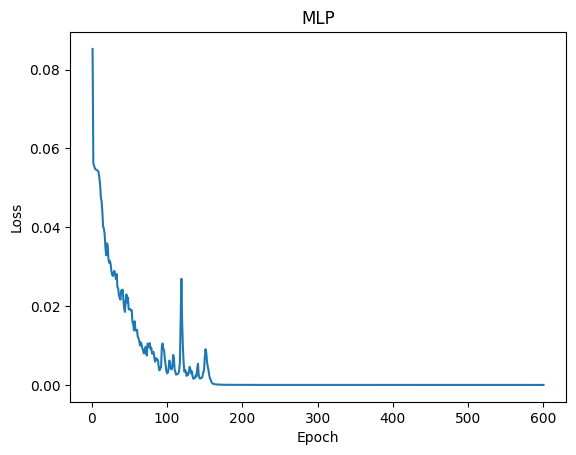

In [269]:
plt.plot(range(1, len(loss_each_epoch_MLP) + 1), loss_each_epoch_MLP)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('MLP')
plt.show()

In [270]:
print('Multi Layer Perceptron (Train Accuracy)')
model_evaluation(train_loader, clf_MLP)

Multi Layer Perceptron (Train Accuracy)
We got 445/445 correct. Accuracy = 100.00%


In [271]:
print('Multi Layer Perceptron (Test Accuracy)')
model_evaluation(test_loader, clf_MLP)

Multi Layer Perceptron (Test Accuracy)
We got 132/192 correct. Accuracy = 68.75%


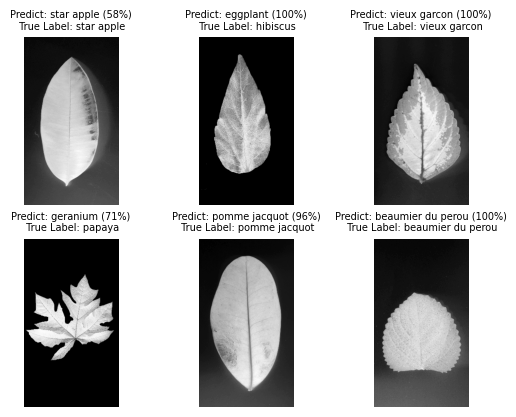

In [272]:
ROW_IMG, N_ROWS = 3, 2

fig = plt.figure()
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    plt.imshow(test_dataset[index][0].squeeze(), cmap='gray_r')
    
    with torch.no_grad():
        clf_MLP.eval()
        X = test_dataset[index][0].reshape(test_dataset[index][0].shape[0], -1).to(device)
        _, probs = clf_MLP(X)
    title = f'Predict: {le.inverse_transform([torch.argmax(probs).item()])[0]} ({torch.max(probs * 100):.0f}%)\n True Label: {le.inverse_transform([test_dataset[index][-1]])[0]}'
    
    plt.title(title, fontsize=7)
plt.show()